#**Stock Prediction analysis**

##Team: The Mean Squares

1. Jeyasri Subramanian [SJSU ID: 014510132]
2. Subarna Chowdhury Soma [SJSU ID: 014549587]
3. Pranav Lodha [SJSU ID: 009468121]
4. Wasae Qureshi [SJSU ID: 014569880]

##**Contributions:**

1. Sector Data downloading,pre-porcessing and computation **[ Pranav & Wasae]**
notebook: StockPrediction_Preprocessing&Computation.ipynb
2. Fractal Clustering and GMM **[Subarna & Jeyasri]**
3. Data insights **[Subarna & Jeyasri]**
4. Result Analysis **[Team]**


In [1]:
   !pip install GMM



     |████████████████████████████████| 92kB 5.5MB/s 
  Created wheel for GMM: filename=GMM-0.3.3-cp36-none-any.whl size=10943 sha256=395ad3858aadb64527c910ab0a2b790d1377afdab6050e8906b3e0a3e8a63304
  Stored in directory: /root/.cache/pip/wheels/a1/c1/d4/7931a8f0e684c97cde85165009e96d1abed97c175fbcf10fec
Successfully built GMM


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture


Mount Google Drive 

In [4]:
link = 'https://drive.google.com/open?id=1BS_KsMqVDCE6P2LDeJBeqbpR6asMmuwG'
fluff, id = link.split('=')
print(id) # Verify that you have everything after '='

1BS_KsMqVDCE6P2LDeJBeqbpR6asMmuwG


In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('computed_data.csv')

#**Data collection and Preparation**

The data downloaded from https://datahub.io/collections/stock-market-data is mapreduced to summarize all stocks data into a single input file


##Load Dataset

In [7]:
stock_data = pd.read_csv('computed_data.csv', low_memory =False)
stock_data.tail()

,stock_name,sector,avg_yearly_returns,yearly_variance
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304
4394,ZUO,Technology,-0.042532,0.014479
4395,ZYME,Healthcare,0.833954,1.018350
4396,ZYNE,Healthcare,0.034941,0.446001
4397,Z,Communication-Services,0.161969,0.107521


In [8]:
stock_data.dtypes

stock_name             object
sector                 object
avg_yearly_returns    float64
yearly_variance       float64
dtype: object

In [9]:
stock_data.stock_name.unique()

array(['AACG', 'AAL', 'AAMC', ..., 'ZYME', 'ZYNE', 'Z'], dtype=object)

In [10]:
stock_data.groupby('sector').stock_name.nunique()

sector
Basic-Materials            170
Communication-Services     190
Consumer-Cyclical          373
Consumer-Defensive         167
Energy                     259
Financial                    3
Financial-Services        1237
Healthcare                 668
Industrials                474
Real-Estate                307
Technology                 462
Utilities                   88
Name: stock_name, dtype: int64

In [11]:

stock_data[stock_data.isnull().any(axis=1)]

,stock_name,sector,avg_yearly_returns,yearly_variance


In [12]:
stock_data.isnull().sum()

stock_name            0
sector                0
avg_yearly_returns    0
yearly_variance       0
dtype: int64

In [13]:
stock_data.dropna(axis=1, how='any')

,stock_name,sector,avg_yearly_returns,yearly_variance
0,AACG,Consumer-Defensive,0.259259,0.000000
1,AAL,Industrials,0.374324,0.480449
2,AAMC,Financial-Services,1.818871,12.961993
3,AAME,Financial-Services,0.089031,0.094460
4,AAOI,Technology,0.136242,0.192417
...,...,...,...,...
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304
4394,ZUO,Technology,-0.042532,0.014479
4395,ZYME,Healthcare,0.833954,1.018350
4396,ZYNE,Healthcare,0.034941,0.446001


In [14]:

columns = ['sector', 'stock_name']

sector_data = stock_data[columns]
sector_data = sector_data.groupby('stock_name').first().reset_index()
sector_data

,stock_name,sector
0,A,Healthcare
1,AA,Basic-Materials
2,AACG,Consumer-Defensive
3,AAL,Industrials
4,AAMC,Financial-Services
...,...,...
4393,ZTS,Healthcare
4394,ZUMZ,Consumer-Cyclical
4395,ZUO,Technology
4396,ZYME,Healthcare


In [15]:
print('Total records : ', stock_data.shape)
print('Total stock data ',len(stock_data.stock_name.unique()))
print('Total Sector data ',len(stock_data.sector.unique()))


Total records :  (4398, 4)
Total stock data  4398
Total Sector data  12


In [16]:
#stock_data = stock_data[(stock_data.year >= 2010) & (stock_data.year <=2017)]
stock_data.head()

,stock_name,sector,avg_yearly_returns,yearly_variance
0,AACG,Consumer-Defensive,0.259259,0.000000
1,AAL,Industrials,0.374324,0.480449
2,AAMC,Financial-Services,1.818871,12.961993
3,AAME,Financial-Services,0.089031,0.094460
4,AAOI,Technology,0.136242,0.192417


#Sector and Stock name Encoding

In [17]:
stock_data["stock_name"] = stock_data["stock_name"].astype('category')
stock_data["stock_category"] = stock_data["stock_name"].cat.codes


In [18]:
stock_data["sector"] = stock_data["sector"].astype('category')
stock_data["sector_category"] = stock_data["sector"].cat.codes

In [19]:
stock_data['stock_name'].unique()

[AACG, AAL, AAMC, AAME, AAOI, ..., ZUMZ, ZUO, ZYME, ZYNE, Z]
Length: 4398
Categories (4398, object): [AACG, AAL, AAMC, AAME, ..., ZUO, ZYME, ZYNE, Z]

In [20]:
stock_data.tail()

,stock_name,sector,avg_yearly_returns,yearly_variance,stock_category,sector_category
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304,4394,2
4394,ZUO,Technology,-0.042532,0.014479,4395,10
4395,ZYME,Healthcare,0.833954,1.018350,4396,7
4396,ZYNE,Healthcare,0.034941,0.446001,4397,7
4397,Z,Communication-Services,0.161969,0.107521,4372,1


In [21]:
stock_data["sector"] = stock_data["sector"].astype('object')
stock_data["stock_name"] = stock_data["stock_name"].astype('object')

In [ ]:
stock_data.dtypes

stock_name             object
sector                 object
avg_yearly_returns    float64
yearly_variance       float64
stock_category          int16
sector_category          int8
dtype: object

#Silhouette score and Elbow curve


In [22]:
data = stock_data.drop('stock_name', axis =1)
data = data.drop('sector', axis =1)


In [27]:
data.dtypes

avg_yearly_returns    float64
yearly_variance       float64
stock_category          int16
sector_category          int8
dtype: object

In [24]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

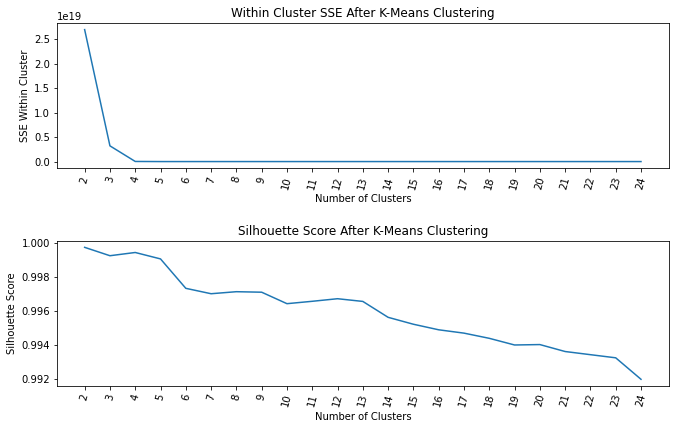

In [26]:
plot_cluster(data, max_loop=25)

In [25]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

# Sector wise Clustering

In [ ]:
def prep_data_to_fit(agg_df4):
    stock_names = agg_df4.stock_name.values
    # Dropping stock_name from data to plot
    data_to_fit = agg_df4.copy().drop('stock_name', axis=1)
    data_to_fit = data_to_fit.copy().drop('sector', axis=1)

    # Getting data as values for clustering algorithms
    data_to_fit = data_to_fit.values
    print (data_to_fit)
    return data_to_fit

In [ ]:
def prep_final_data_to_fit(agg_df4):
    stock_names = agg_df4.stock_name.values
    # Dropping stock_name from data to plot
    data_to_fit = agg_df4.copy().drop('stock_name', axis=1)
    #data_to_fit = data_to_fit.copy().drop('cluster', axis=1)

    # Getting data as values for clustering algorithms
    data_to_fit = data_to_fit.values
    print (data_to_fit)
    return data_to_fit

##K-means clustering

In [ ]:
def kmeans_cluster(data_to_fit, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_to_fit)
    cluster_indices = kmeans.predict(data_to_fit)
    return cluster_indices

   

In [ ]:
def kmeans_plot(cluster_indices):
   fig, ax = plt.subplots()
   scatter = ax.scatter(data_to_fit[:,0],data_to_fit[:,1], s=150,marker='o',edgecolors='black' ,c = cluster_indices, cmap ="rainbow")

   # produce a legend with the unique colors from the scatter
   legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
   ax.add_artist(legend1)
   plt.title('K-Means Clustering') 
   plt.gcf().set_size_inches(22,8)
   plt.show()

## GMM

In [ ]:
def gmm_cluster(data_to_fit,n_clusters):
  print('gmm')
  gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(data_to_fit)
  labels = gmm.predict(data_to_fit)
  gmm_scores = gmm.score_samples(data_to_fit)

  print('Means by sklearn:\n', gmm.means_)
  #print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
  print('Scores by sklearn:\n', gmm_scores[0:20])
  #print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

  fig, ax = plt.subplots()
  scatter = ax.scatter(data_to_fit[:,0],data_to_fit[:,1], s=150,marker='o',edgecolors='black' ,c = labels, cmap ="rainbow")
   # produce a legend with the unique colors from the scatter
  legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
  ax.add_artist(legend1)
  plt.title('GMM Clustering') 
  plt.gcf().set_size_inches(22,8)
  plt.show()


In [ ]:
stock_data.groupby('sector').stock_name.nunique()

sector
Basic-Materials            170
Communication-Services     190
Consumer-Cyclical          373
Consumer-Defensive         167
Energy                     259
Financial                    3
Financial-Services        1237
Healthcare                 668
Industrials                474
Real-Estate                307
Technology                 462
Utilities                   88
Name: stock_name, dtype: int64

#**Fractal Clustering**



Fractal clustering steps:

1. prepare data2
2. plot_cluster(data2, max_loop=25)
3. first_trial = apply_cluster(data2, clusters=3)
4. 
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_name":"count","sector_category":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
cluster_perf_df
5. first_trial_sub = first_trial.query("cluster == 0").reset_index(drop=True)
first_trial_sub

In [30]:
# outlier data
stock_data[(stock_data['avg_yearly_returns'] > 4000)]

,stock_name,sector,avg_yearly_returns,yearly_variance,stock_category,sector_category
2551,MEC,Industrials,4930.373870,2.165139e+08,2551,8
2812,NET,Technology,9249.818289,7.700474e+08,2813,10
3209,PJT,Financial-Services,4511.084807,1.824843e+08,3209,6
4170,VMD,Healthcare,64175.687607,3.592391e+10,4171,7


In [31]:
outlier_free_data= stock_data[(stock_data['avg_yearly_returns'] < 3000) ]
outlier_free_data.head()

,stock_name,sector,avg_yearly_returns,yearly_variance,stock_category,sector_category
0,AACG,Consumer-Defensive,0.259259,0.000000,2,3
1,AAL,Industrials,0.374324,0.480449,3,8
2,AAMC,Financial-Services,1.818871,12.961993,4,6
3,AAME,Financial-Services,0.089031,0.094460,5,6
4,AAOI,Technology,0.136242,0.192417,6,10


In [32]:
stock_data_filter= outlier_free_data[outlier_free_data['sector']=='Financial-Services']
data2 = stock_data_filter.drop('sector', axis =1)


In [33]:
data2.tail(2)

,stock_name,avg_yearly_returns,yearly_variance,stock_category,sector_category
4383,ZION,0.205586,0.127492,4382,6
4391,ZTR,0.112394,0.034901,4392,6


In [35]:
def fractal_clustering(data, n_iterations =3,n_clusters=3):
  for i in range(n_iterations):

    plot_cluster(data, max_loop=25)
    first_trial = apply_cluster(data, clusters=n_clusters)
    cluster_perf_df = (
      first_trial
      .groupby('cluster')
      .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_name":"count","sector_category":"count"})
      .sort_values('avg_yearly_returns')
      .reset_index()
    )

    print(cluster_perf_df.head())
    data = first_trial.query("cluster == 0").reset_index(drop=True)
    print(data.head())
  
  return data



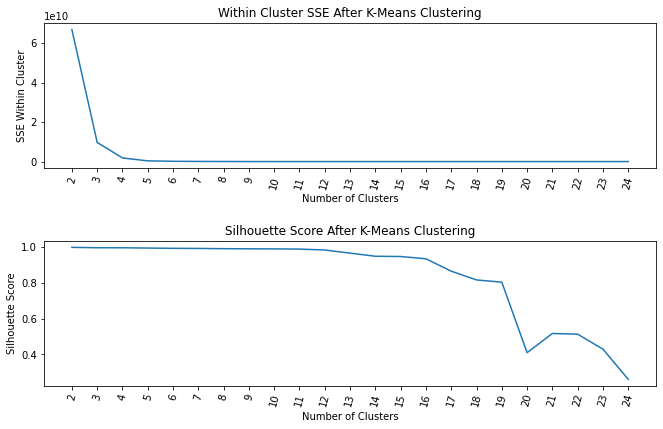

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 9694122102.0
   cluster  avg_yearly_returns  yearly_variance  stock_name  sector_category
0        0            0.151335         3.256643        1232             1232
1        2           32.158679      6672.362173           3                3
2        1          230.679765    318929.184678           1                1
  stock_name  avg_yearly_returns  ...  sector_category  cluster
0       AAMC            1.818871  ...                6        0
1       AAME            0.089031  ...                6        0
2       ABTX            0.136236  ...                6        0
3       ACBI            0.069793  ...                6        0
4      ACGLO            0.475784  ...                6        0

[5 rows x 6 columns]


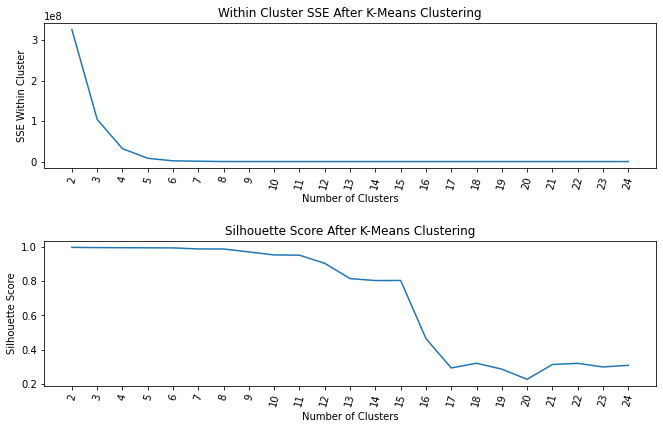

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 104184452.0
   cluster  avg_yearly_returns  yearly_variance  stock_name  sector_category
0        0            0.118186         0.480852        1228             1228
1        2            9.152138       561.656887           3                3
2        1           13.856036      1736.727620           1                1
  stock_name  avg_yearly_returns  ...  sector_category  cluster
0       AAMC            1.818871  ...                6        0
1       AAME            0.089031  ...                6        0
2       ABTX            0.136236  ...                6        0
3       ACBI            0.069793  ...                6        0
4      ACGLO            0.475784  ...                6        0

[5 rows x 6 columns]


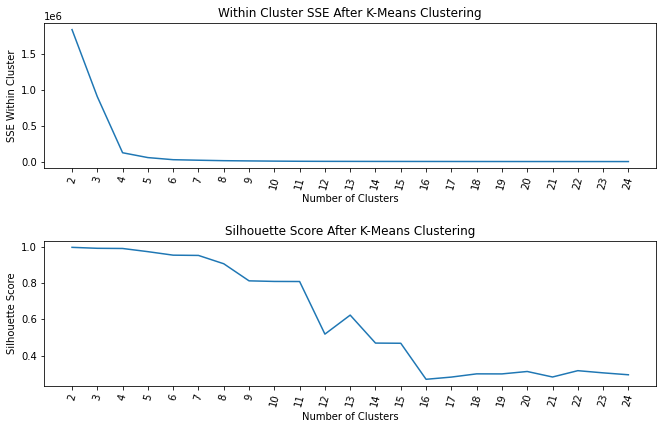

clustering performance
-----------------------------------
silhouette score: 0.99
sse withing cluster: 903652.0
   cluster  avg_yearly_returns  yearly_variance  stock_name  sector_category
0        0            0.102684         0.087994        1222             1222
1        2            2.349708        26.526526           3                3
2        1            4.201082       134.459466           3                3
  stock_name  avg_yearly_returns  ...  sector_category  cluster
0       AAMC            1.818871  ...                6        0
1       AAME            0.089031  ...                6        0
2       ABTX            0.136236  ...                6        0
3       ACBI            0.069793  ...                6        0
4      ACGLO            0.475784  ...                6        0

[5 rows x 6 columns]


In [36]:
data3 = fractal_clustering(data2)


In [ ]:
data3.head()

,stock_name,avg_yearly_returns,yearly_variance,stock_category,sector_category,cluster
0,AAMC,1.818871,12.961993,4,6,0
1,AAME,0.089031,0.094460,5,6,0
2,ABTX,0.136236,0.055758,24,6,0
3,ACBI,0.069793,0.017998,32,6,0
4,ACGLO,0.475784,0.332479,37,6,0


In [ ]:
final_data = data3.query("cluster == 0").reset_index(drop=True)
final_data

,stock_name,avg_yearly_returns,yearly_variance,stock_category,sector_category,cluster
0,AAMC,1.818871,12.961993,4,6,0
1,AAME,0.089031,0.094460,5,6,0
2,ABTX,0.136236,0.055758,24,6,0
3,ACBI,0.069793,0.017998,32,6,0
4,ACGLO,0.475784,0.332479,37,6,0
...,...,...,...,...,...,...
1217,Y,0.121601,0.012964,4357,6,0
1218,ZIONO,0.036033,0.000000,4383,6,0
1219,ZIONP,0.101597,0.000000,4384,6,0
1220,ZION,0.205586,0.127492,4382,6,0


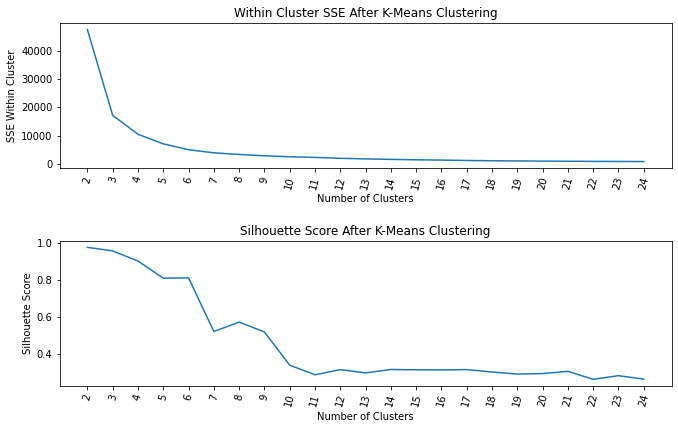

clustering performance
-----------------------------------
silhouette score: 0.81
sse withing cluster: 7053.0


,stock_name,avg_yearly_returns,yearly_variance,stock_category,sector_category,cluster
0,AAMC,1.818871,12.961993,4,6,2
1,AAME,0.089031,0.094460,5,6,0
2,ABTX,0.136236,0.055758,24,6,0
3,ACBI,0.069793,0.017998,32,6,0
4,ACGLO,0.475784,0.332479,37,6,4


In [ ]:
plot_cluster(final_data, max_loop=25)
first_trial = apply_cluster(final_data, clusters=5)
final_data.head()

In [ ]:
data_to_fit = prep_final_data_to_fit(final_data)

[[1.81887066e+00 1.29619928e+01 4.00000000e+00 6.00000000e+00
  2.00000000e+00]
 [8.90314808e-02 9.44603790e-02 5.00000000e+00 6.00000000e+00
  0.00000000e+00]
 [1.36235912e-01 5.57583947e-02 2.40000000e+01 6.00000000e+00
  0.00000000e+00]
 ...
 [1.01597161e-01 0.00000000e+00 4.38400000e+03 6.00000000e+00
  0.00000000e+00]
 [2.05585542e-01 1.27492082e-01 4.38200000e+03 6.00000000e+00
  0.00000000e+00]
 [1.12394487e-01 3.49006376e-02 4.39200000e+03 6.00000000e+00
  0.00000000e+00]]


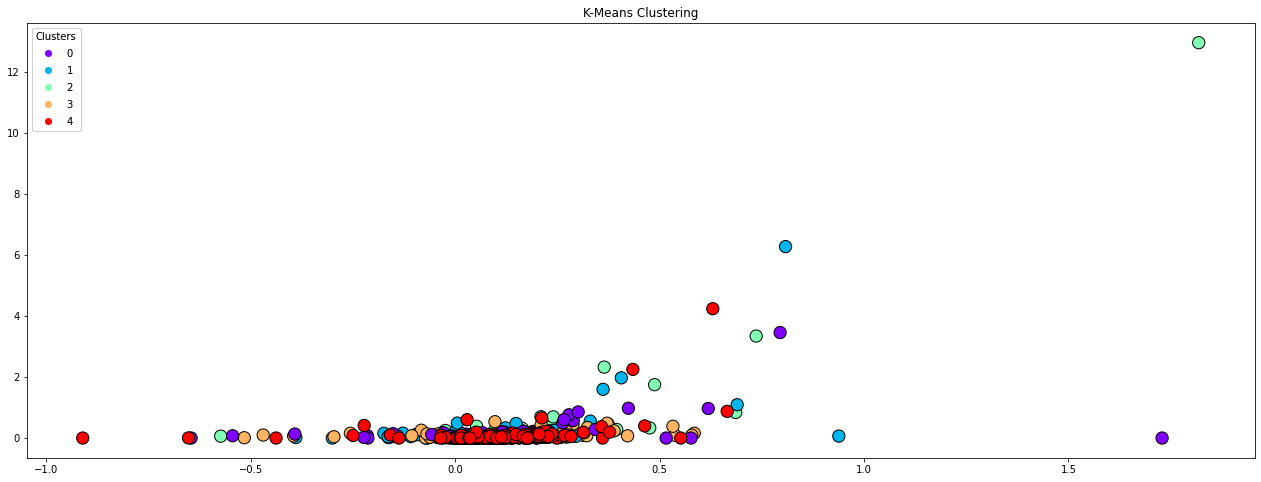

In [ ]:
cluster_indices=kmeans_cluster (data_to_fit, 5)
kmeans_plot(cluster_indices)

gmm
Means by sklearn:
 [[6.84869742e-01 3.51030401e+00 1.55289424e+03 6.00000000e+00
  2.74938144e+00]
 [1.01904782e-01 9.46314353e-02 2.20309345e+03 6.00000000e+00
  0.00000000e+00]
 [3.01108492e-01 7.78681590e-01 3.47378021e+03 6.00000000e+00
  4.00000000e+00]
 [2.73826898e-01 4.51553256e-01 1.92406651e+03 6.00000000e+00
  4.00000000e+00]
 [8.81517157e-02 2.17081496e-02 2.18702474e+03 6.00000000e+00
  0.00000000e+00]]
Scores by sklearn:
 [-13.00174183   3.43619663   5.89726133   7.30306226  -0.26895229
   5.08567405   5.98920749   6.32099054   6.49309057   6.46205591
   5.30907177   2.50934359   3.59055915   7.12841237   3.38193025
   3.54599634   3.20278979   7.26881491   4.02731904   6.83062767]


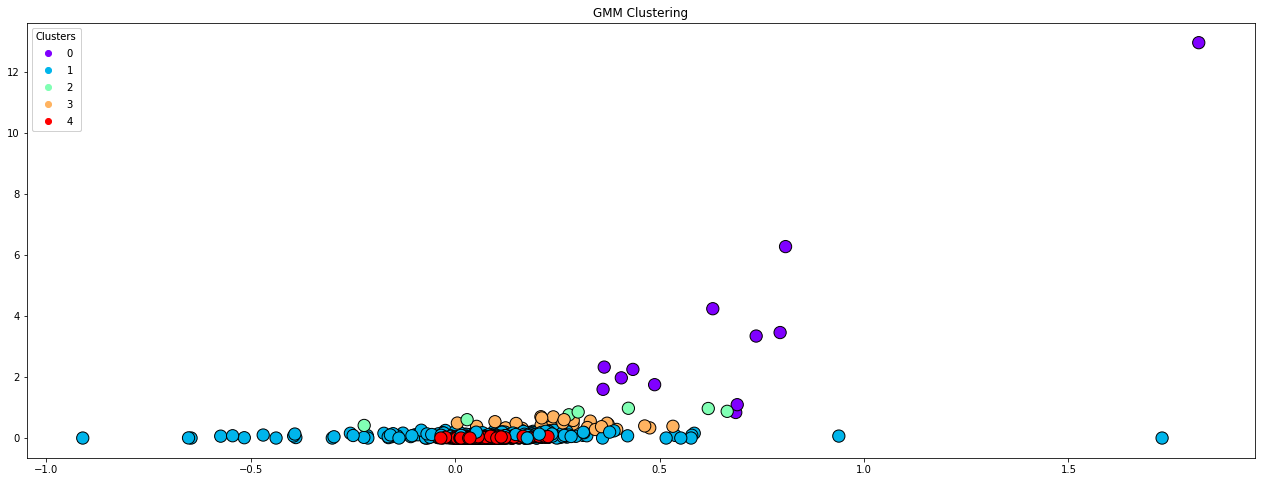

In [ ]:
n_clusters=5
gmm_cluster(data_to_fit, n_clusters)

# Clustering Result Analysis

## Comparison of k-means and GMM:


K-means is a distance based cluster, hence the cluster tries to map the stocks with (returns,variance) datapoints kind of forcefully. Therefore it is taking equal weightage for both returns and variance maps to a centroid. Whereas GMM clustering is a probabilistic clustering which groups  the data points irrespective of centroid.

From the plots, GMM grouped the stocks with similar property together, whereas K-Means tries to map the points in a common circular cluster which is not well separated.





##How does this affect the development of your story about your data set?


We have picked 4398 stocks from 12 different sectors, cleaned and merged it together. For earlier cluster analysis (Assignment-1)we only considered stock data but this time we have incorporated the upper level of stock, which is sector data. Initially (or theoretically) we thought, we should pick stocks with major returns,but after this clustering analysis we come to know, we don't have much data distribution in the volume. After doing some sector wise stock data analysis, one sector has been selected for fractal clustering. With 3 level of fractal clustering, we have picked the data with minimal variance and good volume. So this is giving us a new direction towards achieving our goal. 

##Any new insights?

During the first week (K-means analysis and other clustering analysis), we simply picked the stocks with minimal variance (risk free stocks) and good growth and applied two distance based and two density based clustering methods. But after fractal clustering, We are deciding the good count of stocks with equal distribution from the dataset. Now that some well separated clusters of stocks are formed out of this analysis, we can proceed for further deep analysis considering only those sectors and stocks to fulfill our ultimate goal of predicting good stock market.  

**References:** 
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html